In [68]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

from metaspace import SMInstance
from anndata import AnnData
from metaspace2anndata import dataset_to_anndata

import utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [5]:
from config import date_key, data_dir, store_dir

In [6]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )

In [52]:
md = utils.make_metadata_dict(dss, results)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [46]:
mdt

,Organism,Condition,Organism_Part,Polarity,maldi_matrix,Group,mzmin,mzmax
2023-02-01_06h56m45s,cultured cells,control,skin,positive,DHA,not available,201.163738,1591.141027
2023-02-01_06h55m41s,cultured cells,control,skin,positive,DHA,not available,152.046756,1593.156677
2023-02-01_06h54m38s,cultured cells,control,skin,positive,DHA,not available,201.163738,1596.180509
2023-02-01_06h54m03s,cultured cells,control,skin,positive,DHA,not available,201.163738,1596.180509
2023-02-01_06h53m25s,cultured cells,control,skin,positive,DHA,not available,201.163738,1596.180509
...,...,...,...,...,...,...,...,...
2018-02-13_16h49m05s,homo sapiens (human),normal,breast,negative,None,U Edinburgh,NaN,NaN
2017-09-26_17h17m52s,corn,b73,root,negative,Ag,Iowa State University,NaN,NaN
2017-09-26_16h41m18s,corn,b73,root,negative,Ag,Iowa State University,NaN,NaN
2017-09-04_18h55m50s,homo sapiens (human),diseased,colon,positive,None,ICL,NaN,NaN


# Metadata stats

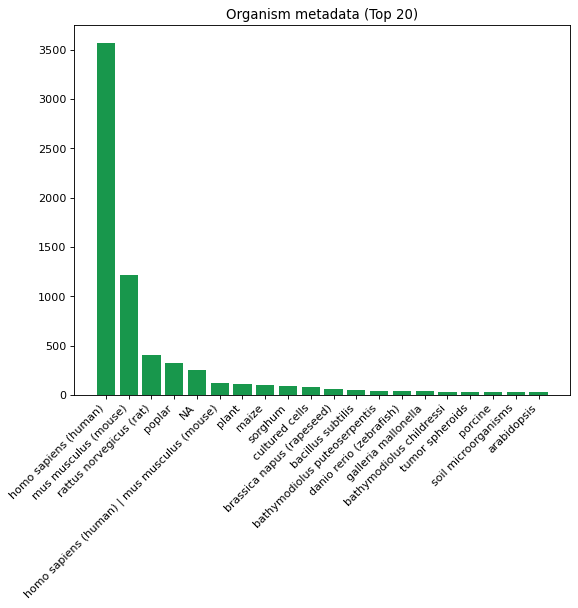

In [30]:
col = 'Organism'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#18974C')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

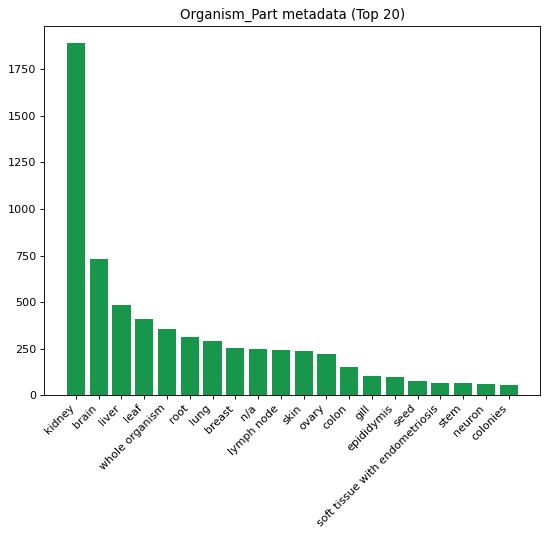

In [33]:
col = 'Organism_Part'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#18974C')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

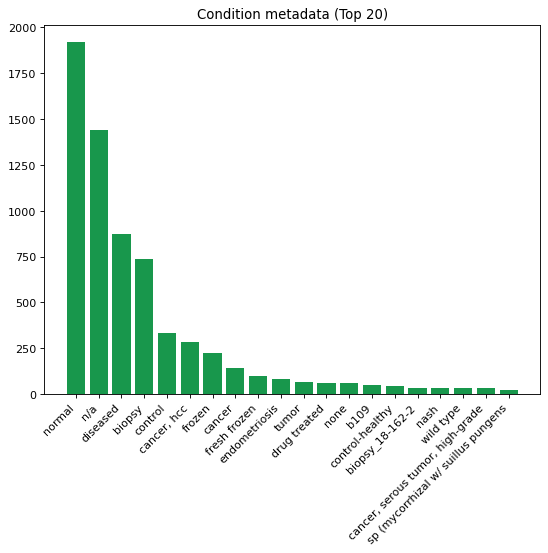

In [34]:
col = 'Condition'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#18974C')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

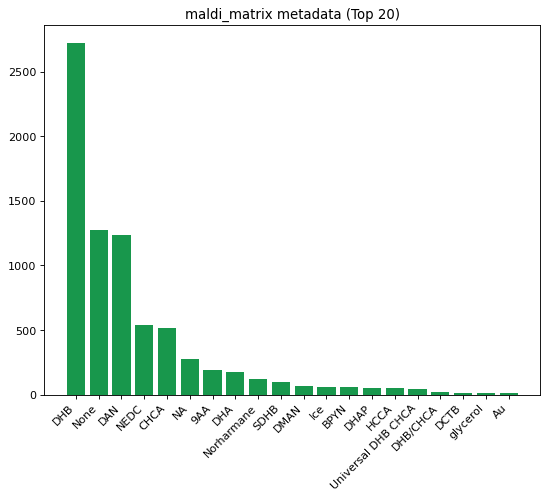

In [53]:
col = 'maldi_matrix'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#18974C')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

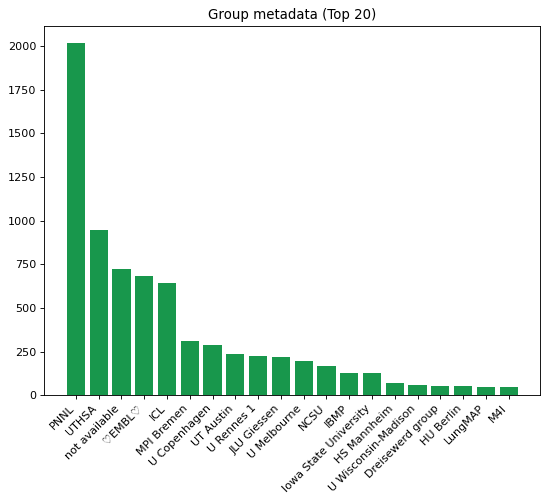

In [54]:
col = 'Group'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#18974C')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

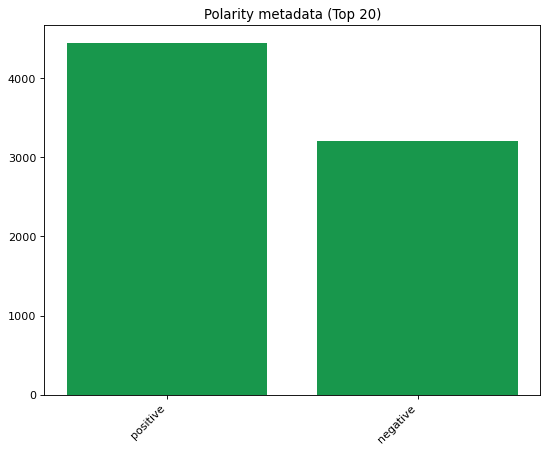

In [61]:
col = 'Polarity'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#18974C')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

<AxesSubplot: xlabel='mzmin', ylabel='Count'>

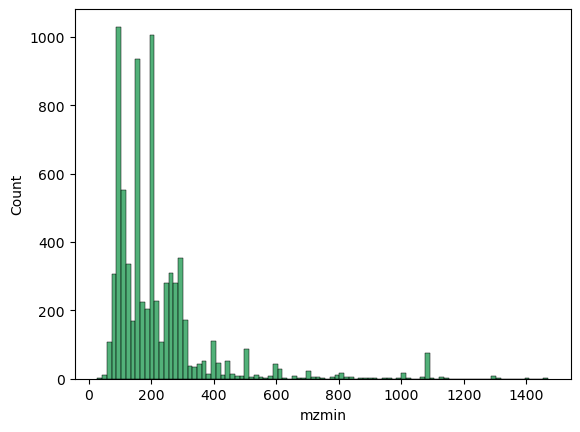

In [57]:
sns.histplot(data=mdt, x='mzmin', color='#18974C')

<AxesSubplot: xlabel='mzmax', ylabel='Count'>

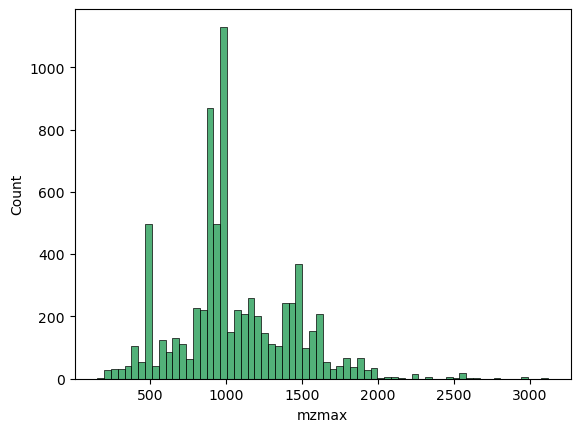

In [58]:
sns.histplot(data=mdt, x='mzmax', color='#18974C')

<AxesSubplot: xlabel='mzrange', ylabel='Count'>

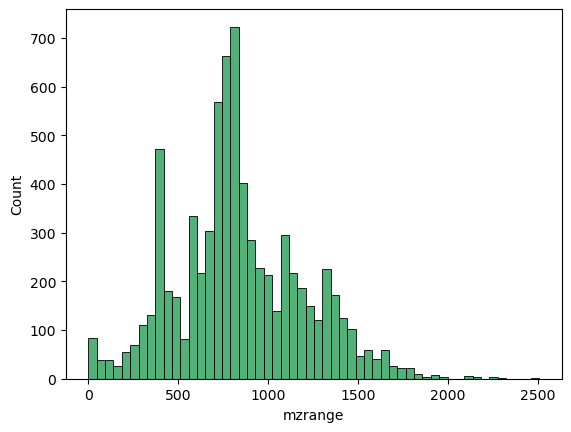

In [60]:
mdt['mzrange'] = mdt['mzmax'] - mdt['mzmin']
sns.histplot(data=mdt, x='mzrange', color='#18974C')

# Database statistics

# Annotation statistics

## Annotations per dataset

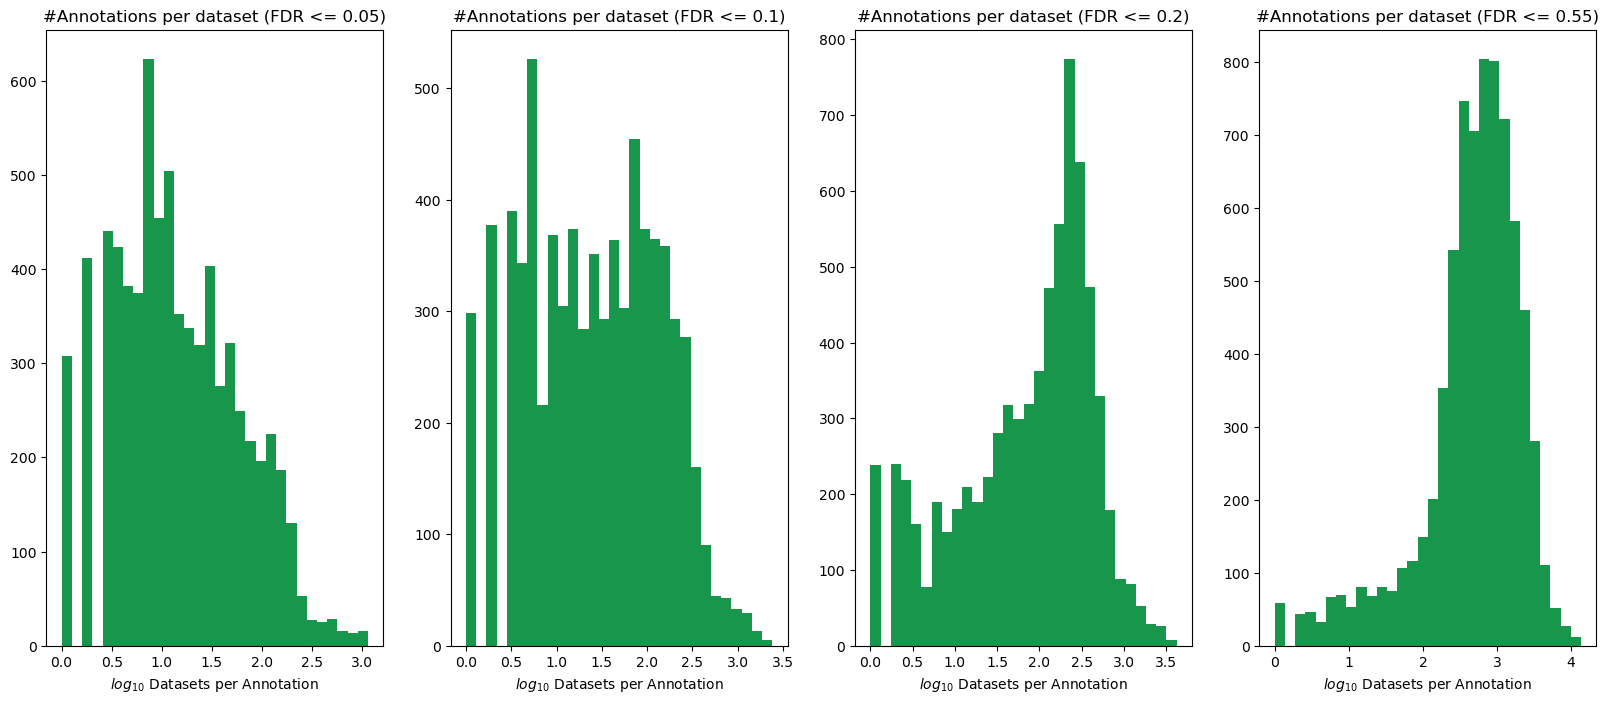

In [84]:
def apd(results, fdr_cutoff=0.05):
    n_anno = []
    for tab in results.values():
        if tab[tab['fdr'] <= fdr_cutoff].shape[0] >0:
            n_anno.append(tab[tab['fdr'] <= fdr_cutoff].shape[0])
            
    return n_anno

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 8))

ax1.hist(np.log10(apd(results, 0.05)), bins=30, color='#18974C')
ax1.set_title(f"#Annotations per dataset (FDR <= {0.05})")
ax1.set_xlabel(r'$log_{10}$ Datasets per Annotation')
         
ax2.hist(np.log10(apd(results, 0.1)), bins=30, color='#18974C')
ax2.set_title(f"#Annotations per dataset (FDR <= {0.1})")
ax2.set_xlabel(r'$log_{10}$ Datasets per Annotation')

ax3.hist(np.log10(apd(results, 0.2)), bins=30, color='#18974C')
ax3.set_title(f"#Annotations per dataset (FDR <= {0.2})")
ax3.set_xlabel(r'$log_{10}$ Datasets per Annotation')
         
ax4.hist(np.log10(apd(results, 0.5)), bins=30, color='#18974C')
ax4.set_title(f"#Annotations per dataset (FDR <= {0.55})")
ax4.set_xlabel(r'$log_{10}$ Datasets per Annotation')
plt.show()

## Datasets per annotation

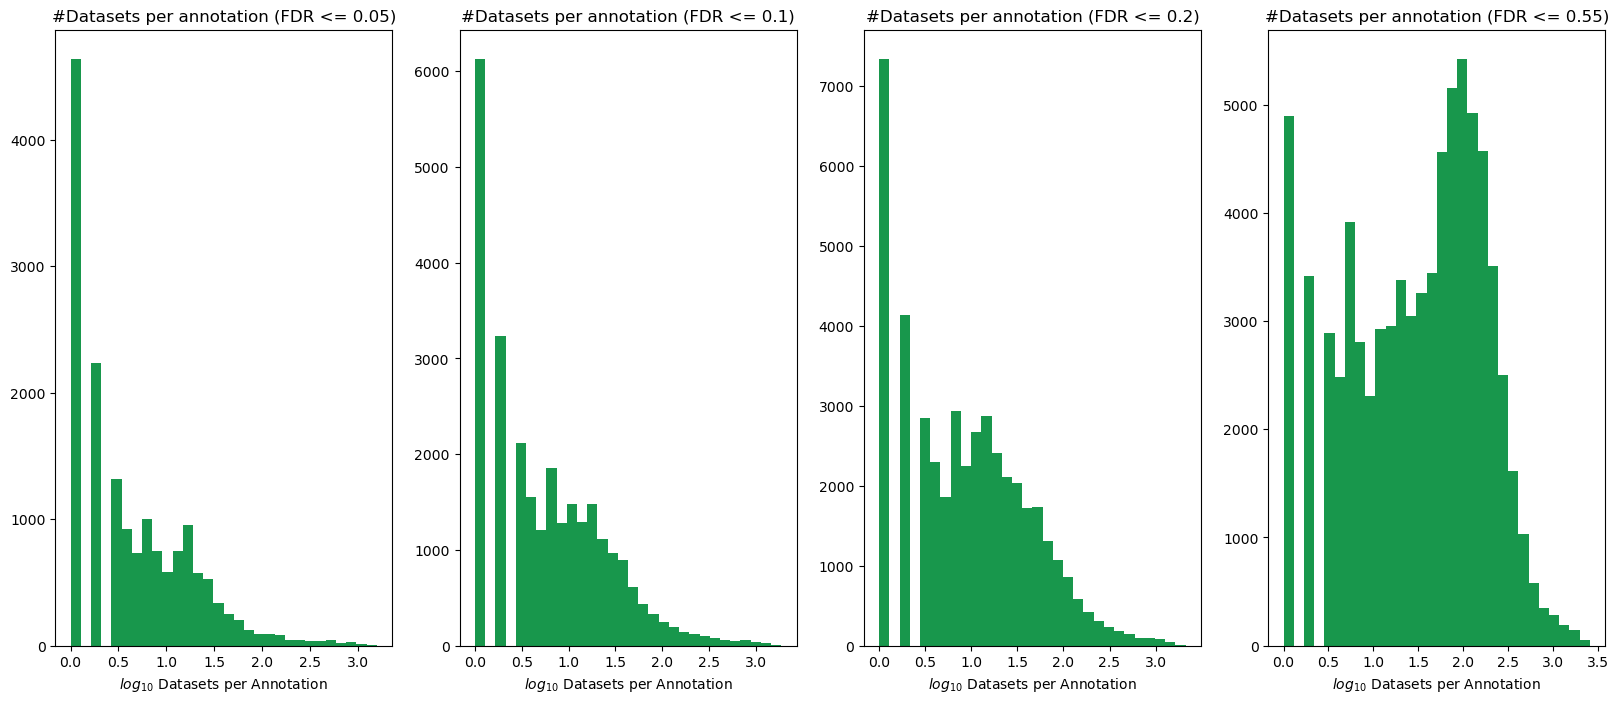

In [82]:
def dpa(results, fdr_cutoff=0.05):
    dpad = defaultdict(int)
    for tab in results.values():
        tmp = list(tab[tab['fdr'] <= fdr_cutoff].index)
        for t in tmp:
            dpad[t] += 1
    return dpad

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 8))

ax1.hist(np.log10(list(dpa(results, 0.05).values())), bins=30, color='#18974C')
ax1.set_title(f"#Datasets per annotation (FDR <= {0.05})")
ax1.set_xlabel(r'$log_{10}$ Datasets per Annotation')
         
ax2.hist(np.log10(list(dpa(results, 0.1).values())), bins=30, color='#18974C')
ax2.set_title(f"#Datasets per annotation (FDR <= {0.1})")
ax2.set_xlabel(r'$log_{10}$ Datasets per Annotation')

ax3.hist(np.log10(list(dpa(results, 0.2).values())), bins=30, color='#18974C')
ax3.set_title(f"#Datasets per annotation (FDR <= {0.2})")
ax3.set_xlabel(r'$log_{10}$ Datasets per Annotation')
         
ax4.hist(np.log10(list(dpa(results, 0.5).values())), bins=30, color='#18974C')
ax4.set_title(f"#Datasets per annotation (FDR <= {0.55})")
ax4.set_xlabel(r'$log_{10}$ Datasets per Annotation')
plt.show()

# Metabolite class statistics

In [87]:
hmdb4_metclasses = pd.read_csv(os.path.join(data_dir, 'databases', 'HMDB_v4.csv'))

In [89]:
super_class_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses.super_class))
class_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses['class']))
sub_class_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses.sub_class))
status_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses.status))

In [90]:

# For each dataset, make a list of lists with HMDB accessions
fdr_cutoff = 0.1

metaspace_annotation_super_class = {}
metaspace_annotation_class = {}
metaspace_annotation_sub_class = {}

for i in tqdm(results.keys()):
    # Get all moleculeids:
    tmp_ids = list(results[i][results[i]['fdr'] <= fdr_cutoff]['moleculeIds'])
    
    metaspace_annotation_super_class[i] = []
    metaspace_annotation_class[i] = []
    metaspace_annotation_sub_class[i] = []
    for io in tmp_ids:
        ion = ast.literal_eval(io)
        if (len(ion)) == 1:
            if ion[0] in super_class_dict.keys():
                metaspace_annotation_super_class[i].append([super_class_dict[ion[0]]])
                metaspace_annotation_class[i].append([class_dict[ion[0]]])
                metaspace_annotation_sub_class[i].append([sub_class_dict[ion[0]]])
        else:
            tmp_super_class = []
            tmp_class = []
            tmp_sub_class = []
            for ann in ion:
                if status_dict.get(ann, 'not found') == 'quantified' or status_dict.get(ann, 'not found') == 'detected':
                    tmp_super_class.append(super_class_dict[ann])
                    tmp_class.append(class_dict[ann])
                    tmp_sub_class.append(sub_class_dict[ann])
            if len(tmp_super_class)>0: metaspace_annotation_super_class[i].append(tmp_super_class)
            if len(tmp_class)>0: metaspace_annotation_class[i].append(tmp_class)
            if len(tmp_sub_class)>0: metaspace_annotation_sub_class[i].append(tmp_sub_class)

  0%|          | 0/7443 [00:00<?, ?it/s]


KeyError: 'moleculeIds'

In [ ]:
tmp_dict = metaspace_annotation_super_class
cd = defaultdict(int)
for key, val in tmp_dict.items():
    tmp_classes = list(set(utils.flatten(val)))
    for it in tmp_classes:
        cd[it] += 1
cd=dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMCB super-class at least once per dataset')
plt.show()

In [ ]:
tmp_dict = metaspace_annotation_class
cd = defaultdict(int)
for key, val in tmp_dict.items():
    tmp_classes = list(set(utils.flatten(val)))
    for it in tmp_classes:
        cd[it] += 1
cd=dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd= {list(cd.keys())[i]: list(cd.values())[i] for i in range(20)}
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMCB class at least once per dataset')
plt.show()

In [ ]:
tmp_dict = metaspace_annotation_sub_class
cd = defaultdict(int)
for key, val in tmp_dict.items():
    tmp_classes = list(set(utils.flatten(val)))
    for it in tmp_classes:
        cd[it] += 1
cd=dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd= {list(cd.keys())[i]: list(cd.values())[i] for i in range(20)}
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMDB sub-class at least once per dataset')
plt.show()

## Frequency of terms in datasets

In [ ]:
tmp_dict = metaspace_annotation_super_class
cd = defaultdict(float)
tmp_l = []
for key, val in tmp_dict.items():
    tmp_classes = [random.choice(x) for x in val]
    tmp_dict = defaultdict(int)
    for it in tmp_classes:
        tmp_dict[it] += 1
    tmp_dict = {key: val/sum(tmp_dict.values()) for key, val in tmp_dict.items()}
    for k2, v2 in tmp_dict.items():
        cd[k2] += v2
cd = {key: val/sum(cd.values()) for key, val in cd.items()}
cd = dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd = {list(cd.keys())[i]: list(cd.values())[i] for i in range(20)}
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMDB super-class frequency per dataset (if present)')
plt.show()

In [ ]:
tmp_dict = metaspace_annotation_class
cd = defaultdict(float)
tmp_l = []
for key, val in tmp_dict.items():
    tmp_classes = [random.choice(x) for x in val]
    tmp_dict = defaultdict(int)
    for it in tmp_classes:
        tmp_dict[it] += 1
    tmp_dict = {key: val/sum(tmp_dict.values()) for key, val in tmp_dict.items()}
    for k2, v2 in tmp_dict.items():
        cd[k2] += v2
cd = {key: val/sum(cd.values()) for key, val in cd.items()}
cd = dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd = {list(cd.keys())[i]: list(cd.values())[i] for i in range(20)}
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMDB class frequency per dataset (if present)')
plt.show()

In [ ]:
tmp_dict = metaspace_annotation_sub_class
cd = defaultdict(float)
tmp_l = []
for key, val in tmp_dict.items():
    tmp_classes = [random.choice(x) for x in val]
    tmp_dict = defaultdict(int)
    for it in tmp_classes:
        tmp_dict[it] += 1
    tmp_dict = {key: val/sum(tmp_dict.values()) for key, val in tmp_dict.items()}
    for k2, v2 in tmp_dict.items():
        cd[k2] += v2
cd = {key: val/sum(cd.values()) for key, val in cd.items()}
cd = dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd = {list(cd.keys())[i]: list(cd.values())[i] for i in range(20)}
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMDB sub-class frequency per dataset (if present)')
plt.show()